# Automarken aufgrund von Bildern erkennen

Im dritten Versuch lassen wir die Daten auf dem lokalen Drive und arbeiten mit der lokalen CPU. 
Die Daten wurden lokal vorbereitet über das Python Script 'Autodata_local_prep.py'

In [2]:
import os, shutil, glob, re
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Convolution2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics as sk_metrics
import itertools
import matplotlib.pyplot as plt
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [65]:
# lokaler pfad
train_path = 'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/Datensatz/train'
valid_path = 'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/Datensatz/valid'
test_path =  'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/Datensatz/test'

In [3]:
# lokaler Beispiel pfad
train_path = 'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/old_test/train'
valid_path = 'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/old_test/valid'
test_path =  'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/old_test/test'

In [4]:
all_subdirs = os.listdir(train_path)
len(all_subdirs)

4

# Bilddaten pre-processen und anzeigen

In [5]:
# Load dataset for display
para_kwargs = dict(
    labels='inferred', 
    label_mode='int',   # for fitting use 'categorical' for print use 'int'
    color_mode='rgb', 
    batch_size=32, 
    image_size=(112, 112))

train_ds = keras.preprocessing.image_dataset_from_directory(train_path, **para_kwargs, seed=1)
valid_ds = keras.preprocessing.image_dataset_from_directory(valid_path, **para_kwargs, seed=1)
test_ds = keras.preprocessing.image_dataset_from_directory(test_path, **para_kwargs, seed=1)

Found 3552 files belonging to 4 classes.
Found 1184 files belonging to 4 classes.
Found 1184 files belonging to 4 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Acura', 'Ferrari', 'Ford', 'Lamborghini']


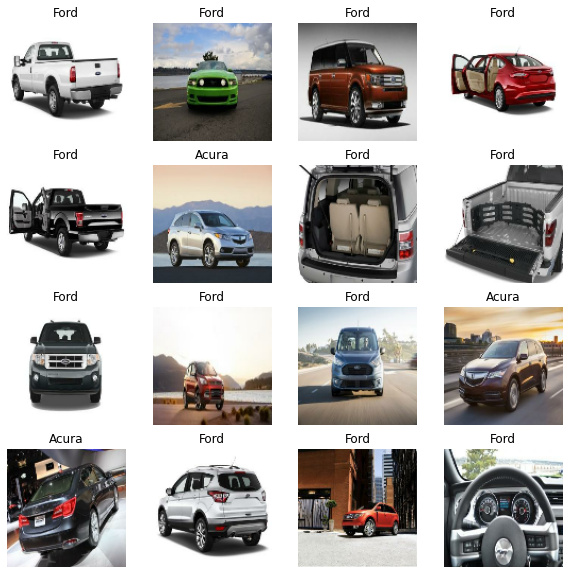

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# Load dataset again now for fitting (with different label_mode)
para_kwargs = dict(
    labels='inferred', 
    label_mode='categorical',   # for fitting = 'categorical' for print = 'int'
    color_mode='rgb', 
    batch_size=64, 
    image_size=(112, 112))

train_ds = keras.preprocessing.image_dataset_from_directory(train_path, **para_kwargs, seed=1)
valid_ds = keras.preprocessing.image_dataset_from_directory(valid_path, **para_kwargs, seed=1)
test_ds = keras.preprocessing.image_dataset_from_directory(test_path, **para_kwargs, seed=1)

Found 3552 files belonging to 4 classes.
Found 1184 files belonging to 4 classes.
Found 1184 files belonging to 4 classes.


In [9]:
# Standardize data
from tensorflow.keras import layers
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Create Model

In [10]:
# Define hyperparameter of the CNN
input_shape = (112, 112, 3)
# batch_size = 32
nb_classes = len(class_names)
kernel_size = (3, 3)
pool_size = (2, 2)

In [33]:
# create own Model
# define CNN with 2 convolution blocks and 2 fully connected layers
# includes 1 MaxPooling layers and 1 Dropout layer
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# summarize model along with number of model weights
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 112, 112, 8)       224       
_________________________________________________________________
activation_4 (Activation)    (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 8)       584       
_________________________________________________________________
activation_5 (Activation)    (None, 112, 112, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25088)            

In [32]:
# Alternative: Pre-trained Model auswählen (aus TF-Hub)
model_name = "mobilenet_v2_100_224"
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4" 
IMAGE_SIZE = (224, 224, 3)
BATCH_SIZE = 32
print(f"\nAusgewaehltes model: {model_name} : {model_handle}")
print(f"\nBild-Groesse {IMAGE_SIZE}")

# CNN zusammenstellen mit Anzahl Klassen wie im Datenset 
print("\nModell erstellen mit", model_handle)
model2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names), 
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model2.build((None,)+IMAGE_SIZE)
model2.summary()



Ausgewaehltes model: mobilenet_v2_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4

Bild-Groesse (224, 224, 3)

Modell erstellen mit https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


# Train Model

In [12]:
# Optionally create a callback that saves the model's weights
'''checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)'''

In [13]:
# train the model
history=model.fit(train_ds
                  , epochs=15
                  , verbose=1
                  , validation_data=(valid_ds)
#                  , callbacks=[cp_callback]    # Pass callback to training
                 )  

Epoch 1/15
56/56 [==============================] - 38s 632ms/step - loss: 0.8186 - accuracy: 0.6859 - val_loss: 0.6336 - val_accuracy: 0.7508
Epoch 2/15
56/56 [==============================] - 30s 519ms/step - loss: 0.5693 - accuracy: 0.7800 - val_loss: 0.4749 - val_accuracy: 0.8302
Epoch 3/15
56/56 [==============================] - 30s 525ms/step - loss: 0.3919 - accuracy: 0.8599 - val_loss: 0.4460 - val_accuracy: 0.8269
Epoch 4/15
56/56 [==============================] - 30s 527ms/step - loss: 0.2790 - accuracy: 0.8915 - val_loss: 0.3141 - val_accuracy: 0.8953
Epoch 5/15
56/56 [==============================] - 30s 524ms/step - loss: 0.1731 - accuracy: 0.9421 - val_loss: 0.2986 - val_accuracy: 0.9198
Epoch 6/15
56/56 [==============================] - 30s 518ms/step - loss: 0.1060 - accuracy: 0.9650 - val_loss: 0.3006 - val_accuracy: 0.9215
Epoch 7/15
56/56 [==============================] - 30s 527ms/step - loss: 0.0720 - accuracy: 0.9830 - val_loss: 0.3013 - val_accuracy: 0.9189

In [13]:
# Optionally save the model
'''model.save('C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/saved_model')'''

INFO:tensorflow:Assets written to: C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/saved_model\assets


# Evaluate Model

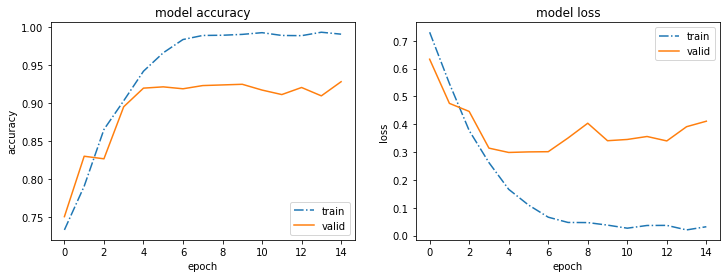

In [14]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

# Prediction with Testdata

In [17]:
# Load dataset again now for displaying (with different label_mode)
para_kwargs = dict(
    labels='inferred', 
    label_mode='int',   # for fitting = 'categorical' for print = 'int'
    color_mode='rgb', 
    batch_size=64, 
    image_size=(112, 112))

train_ds = keras.preprocessing.image_dataset_from_directory(train_path, **para_kwargs, seed=1)
valid_ds = keras.preprocessing.image_dataset_from_directory(valid_path, **para_kwargs, seed=1)
test_ds = keras.preprocessing.image_dataset_from_directory(test_path, **para_kwargs, seed=1)

Found 3552 files belonging to 4 classes.
Found 1184 files belonging to 4 classes.
Found 1184 files belonging to 4 classes.


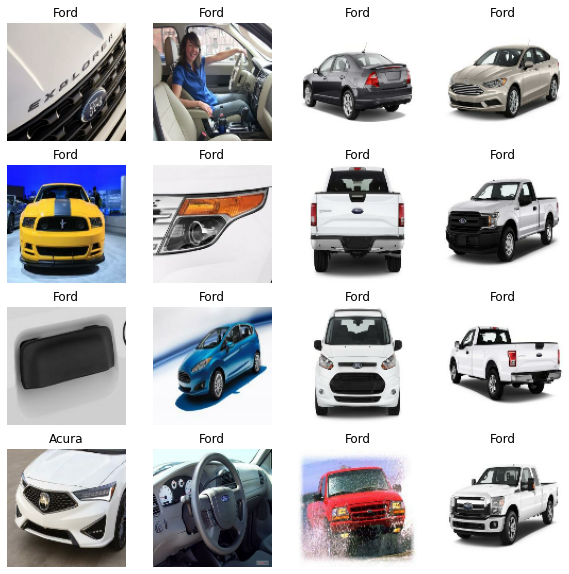

In [18]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [19]:
# Predict Brands on Test Data
pred=model.predict(test_ds)
y_pred = np.argmax(pred, axis=1)
y_pred

array([2, 2, 3, ..., 2, 2, 2], dtype=int64)

In [20]:
y_true = np.concatenate([y_true for x, y_true in test_ds], axis=0)
y_true

array([0, 2, 2, ..., 0, 0, 2])

In [21]:
print(all_subdirs)
print(confusion_matrix(y_true, y_pred))

['Acura', 'Ferrari', 'Ford', 'Lamborghini']
[[ 56   1 171   6]
 [  1   0  15   2]
 [160   7 686  29]
 [ 11   0  38   1]]


(-0.5, 111.5, 111.5, -0.5)

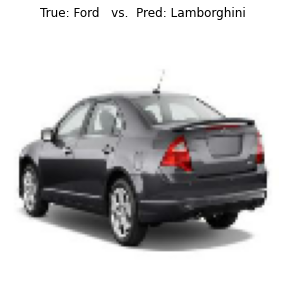

In [24]:
image_number = 2
plt.figure(figsize=(5, 5))
plt.imshow(image_batch[image_number].numpy().astype("uint8"))
true_label = label_batch[image_number]
pred_label = y_pred[image_number]
plt.title('True: ' + class_names[true_label] + '   vs.  Pred: ' + class_names[pred_label])
plt.axis("off")

In [25]:
target_names = class_names
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Acura       0.25      0.24      0.24       234
     Ferrari       0.00      0.00      0.00        18
        Ford       0.75      0.78      0.77       882
 Lamborghini       0.03      0.02      0.02        50

    accuracy                           0.63      1184
   macro avg       0.26      0.26      0.26      1184
weighted avg       0.61      0.63      0.62      1184

